Installation of R on google colab:

In [0]:
cat(system('python3 -c "from google.colab import drive\ndrive.mount()"', intern=TRUE), sep='\n', wait=TRUE)

In [0]:
?system
version

In [0]:
install.packages("rgl", repos = "http://cran.rstudio.com/")
install.packages("ConsRank", repos = "http://cran.rstudio.com/")
library("ConsRank")

In [0]:
system("add-apt-repository -y ppa:marutter/rrutter")
system("add-apt-repository -y ppa:marutter/c2d4u")
system("apt-get update")
system("apt install -y r-cran-rstan")

In [25]:
install.packages("ggplot2")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [0]:
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")

In [0]:
BiocManager::install(version="3.9", ask=FALSE)

In [17]:
BiocManager::install("DESeq2", version="3.9")

Old packages: 'backports', 'curl', 'dbplyr', 'ellipsis', 'farver', 'glue',
  'haven', 'modelr', 'processx', 'rex', 'rprojroot', 'rversions',
  'systemfonts', 'tidyr', 'tinytex', 'xfun', 'nlme'



In [0]:
library(ggplot2)
library( "DESeq2" )



---

Analyze gene count data using Deseq2 

---



Download gene count data

In [30]:
countsName <- "https://bioconnector.github.io/workshops/data/airway_scaledcounts.csv"
download.file(countsName, destfile = "airway_scaledcounts.csv", method = "auto")

countData <- read.csv('airway_scaledcounts.csv', header = TRUE, sep = ",")
head(countData)

,ensgene,SRR1039508,SRR1039509,SRR1039512,SRR1039513,SRR1039516,SRR1039517,SRR1039520,SRR1039521
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,ENSG00000000003,723,486,904,445,1170,1097,806,604
2,ENSG00000000005,0,0,0,0,0,0,0,0
3,ENSG00000000419,467,523,616,371,582,781,417,509
4,ENSG00000000457,347,258,364,237,318,447,330,324
5,ENSG00000000460,96,81,73,66,118,94,102,74
6,ENSG00000000938,0,0,1,0,2,0,0,0


Download Meta Data

In [32]:
metaDataName <- "https://bioconnector.github.io/workshops/data/airway_metadata.csv"
download.file(metaDataName, destfile = "airway_metadata.csv", method = "auto")

metaData <- read.csv('airway_metadata.csv', header = TRUE, sep = ",")
metaData

id,dex,celltype,geo_id
<fct>,<fct>,<fct>,<fct>
SRR1039508,control,N61311,GSM1275862
SRR1039509,treated,N61311,GSM1275863
SRR1039512,control,N052611,GSM1275866
SRR1039513,treated,N052611,GSM1275867
SRR1039516,control,N080611,GSM1275870
SRR1039517,treated,N080611,GSM1275871
SRR1039520,control,N061011,GSM1275874
SRR1039521,treated,N061011,GSM1275875


Construct DESEQDataSet Object


In [33]:
dds <- DESeqDataSetFromMatrix(countData=countData, 
                              colData=metaData, 
                              design=~dex, tidy = TRUE)

converting counts to integer mode



In [34]:
#Design specifies how the counts from each gene depend on our variables in the metadata
#For this dataset the factor we care about is our treatment status (dex)
#tidy=TRUE argument, which tells DESeq2 to output the results table with rownames as a first #column called 'row.

#let's see what this object looks like
dds

class: DESeqDataSet 
dim: 38694 8 
metadata(1): version
assays(1): counts
rownames(38694): ENSG00000000003 ENSG00000000005 ... ENSG00000283120
  ENSG00000283123
rowData names(0):
colnames(8): SRR1039508 SRR1039509 ... SRR1039520 SRR1039521
colData names(4): id dex celltype geo_id

Run DESEQ function

In [35]:
dds <- DESeq(dds)

#estimateSizeFactors
#This calculates the relative library depth of each sample 

#estimateDispersions
#estimates the dispersion of counts for each gene 

#nbinomWaldTest
#calculates the significance of coefficients in a Negative Binomial GLM using the size and dispersion outputs

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



Results Table

In [36]:
res <- results(dds)
head(results(dds, tidy=TRUE))

,row,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,ENSG00000000003,747.1941954,-0.35070296,0.1682421,-2.0845139,0.03711345,0.1630172
2,ENSG00000000005,0.0000000,NA,NA,NA,NA,NA
3,ENSG00000000419,520.1341601,0.20610728,0.1010415,2.0398279,0.04136747,0.1759366
4,ENSG00000000457,322.6648439,0.02452701,0.1451339,0.1689958,0.86579996,0.9616825
5,ENSG00000000460,87.6826252,-0.14714263,0.2569954,-0.5725496,0.56694971,0.8158052
6,ENSG00000000938,0.3191666,-1.73228897,3.4936010,-0.4958463,0.62000288,NA


Summary of differential gene expression

In [37]:
summary(res)


out of 25258 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 1564, 6.2%
LFC < 0 (down)     : 1188, 4.7%
outliers [1]       : 142, 0.56%
low counts [2]     : 9971, 39%
(mean count < 10)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



Sort summary list by p-value

In [75]:
res <- res[order(res$padj),]
head(res)

log2 fold change (MLE): dex treated vs control 
Wald test p-value: dex treated vs control 
DataFrame with 6 rows and 6 columns
                        baseMean    log2FoldChange              lfcSE
                       <numeric>         <numeric>          <numeric>
ENSG00000152583 954.770931565544  4.36835876752575  0.237130551769247
ENSG00000179094 743.252688449073  2.86388859808246  0.175565883861847
ENSG00000116584 2277.91345410747 -1.03470049033618 0.0650825556275832
ENSG00000189221 2383.75370672631   3.3415440681344  0.212409078962377
ENSG00000120129 3440.70375496308  2.96521081657061  0.203697777239671
ENSG00000148175 13493.9203682606  1.42716829196439  0.100381138942341
                             stat               pvalue                 padj
                        <numeric>            <numeric>            <numeric>
ENSG00000152583  18.4217458903255 8.79213669087585e-76 1.33156910183315e-71
ENSG00000179094  16.3123297937318 8.06567900605327e-60 6.10773542733384e-56
ENSG00000

Plot Counts

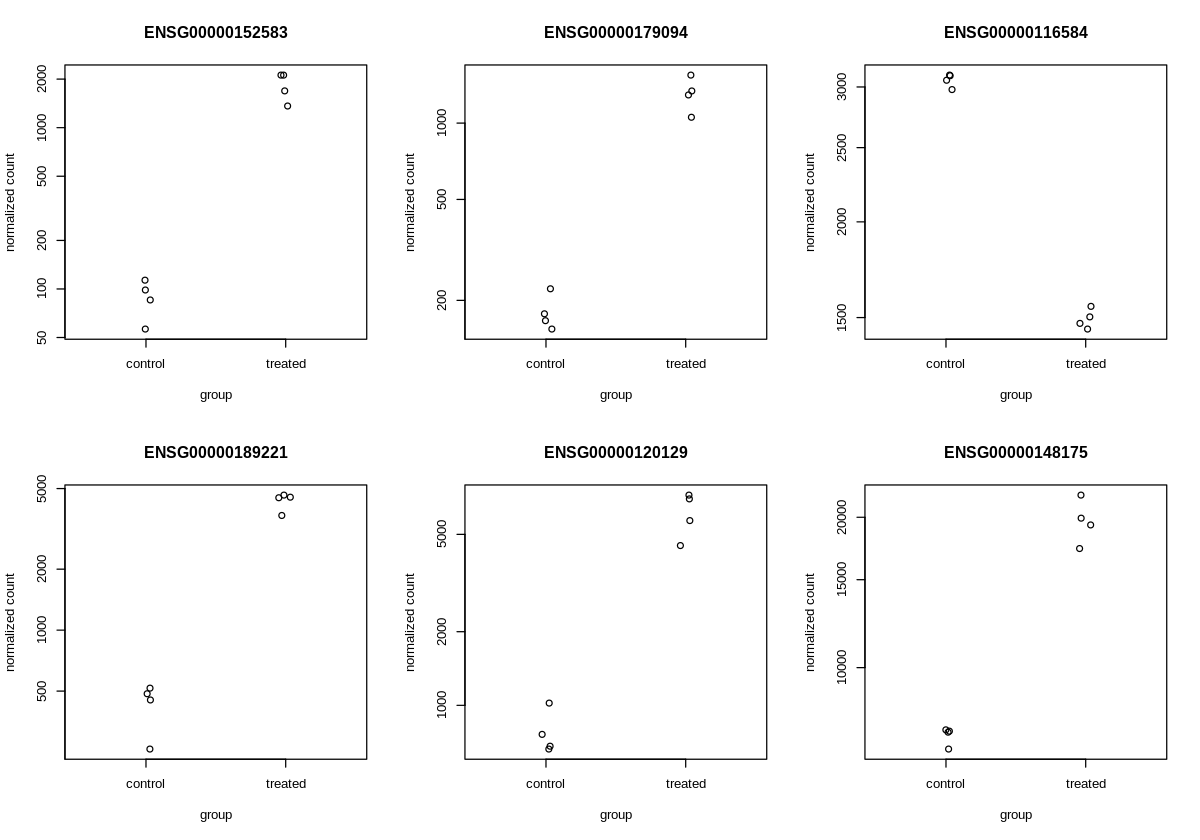

In [74]:
#we can use plotCounts fxn to compare the normalized counts
#between treated and control groups for our top 6 genes
par(mfrow=c(2,3))

plotCounts(dds, gene="ENSG00000152583", intgroup="dex")
plotCounts(dds, gene="ENSG00000179094", intgroup="dex")
plotCounts(dds, gene="ENSG00000116584", intgroup="dex")
plotCounts(dds, gene="ENSG00000189221", intgroup="dex")
plotCounts(dds, gene="ENSG00000120129", intgroup="dex")
plotCounts(dds, gene="ENSG00000148175", intgroup="dex")

#Next steps in exploring these data...BLAST to database to find associated gene function

Volcano Plot

In [0]:
library(repr)
options(repr.plot.width=10, repr.plot.height=7) 

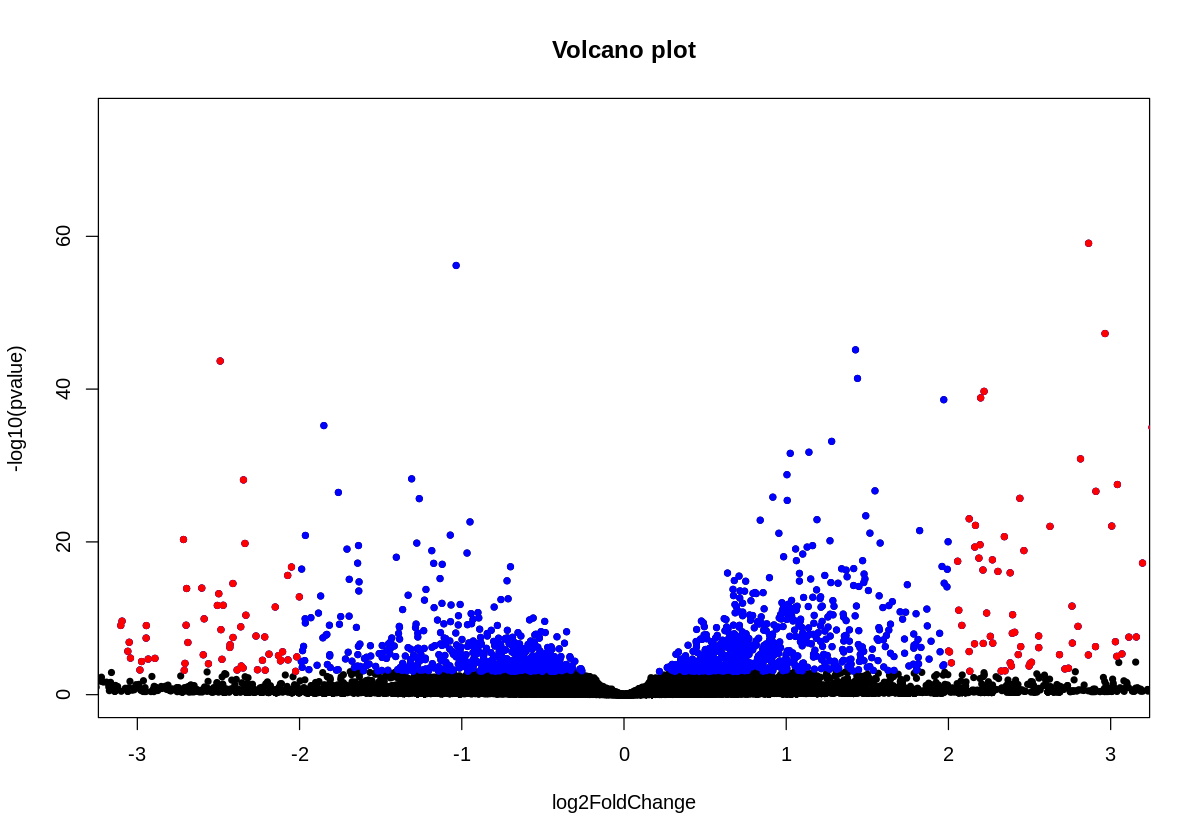

In [71]:
#reset par
par(mfrow=c(1,1))
# Make a basic volcano plot
with(res, plot(log2FoldChange, -log10(pvalue), pch=20, main="Volcano plot", xlim=c(-3,3)))

# Add colored points: blue if padj<0.01, red if log2FC>1 and padj<0.05)
with(subset(res, padj<.01 ), points(log2FoldChange, -log10(pvalue), pch=20, col="blue"))
with(subset(res, padj<.01 & abs(log2FoldChange)>2), points(log2FoldChange, -log10(pvalue), pch=20, col="red"))


In [0]:
#First we need to transform the raw count data
#vst function will perform variance stabilizing transformation

vsdata <- vst(dds, blind=FALSE)

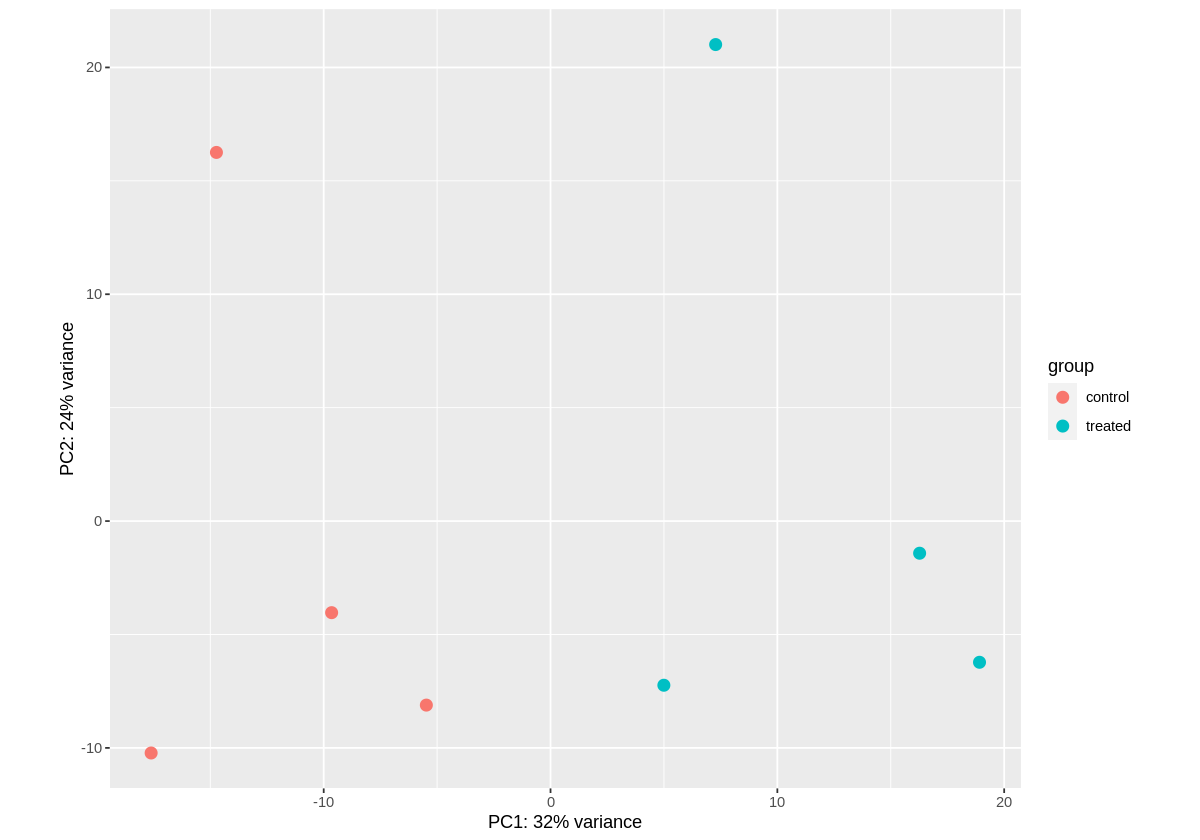

In [73]:
plotPCA(vsdata, intgroup="dex")
#using the DESEQ2 plotPCA fxn we can look at how our samples group by treatment
